To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth?tab=readme-ov-file#-installation-instructions).

**[NEW] As of Novemeber 2024, Unsloth now supports vision finetuning!**

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

**This notebook finetunes Qwen2 VL 7B to convert handwritten math formulas into machine readable LaTeX form.**

In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

* We support Llama 3.2 Vision 11B, 90B; Pixtral; Qwen2VL 2B, 7B, 72B; and any Llava variant like Llava NeXT!
* We support 16bit LoRA via `load_in_4bit=False` or 4bit QLoRA. Both are accelerated and use much less memory!

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-2B-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.8: Fast Qwen2_Vl vision patching. Transformers: 4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

<a name="Data"></a>
### Data Prep
We'll be using a sampled dataset of handwritten maths formulas. The goal is to convert these images into a computer readable form - ie in LaTeX form, so we can render it. This can be very useful for complex formulas.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [4]:
#Mounting google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Extracting the data zip file into the output folder Augmented_Khatt
import zipfile

# Specify the path to the zip file
zip_file_path = "/content/drive/MyDrive/OCR/Processed.zip"
extract_to_path = "/content/Augmented_khatt"  # Specify where to extract

# Open and extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Folder unzipped to {extract_to_path}")

Folder unzipped to /content/Augmented_khatt


In [6]:
#Importing required dependencies, and specifying input/output pathes.
import json
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt

test_images_path = "/content/Augmented_khatt/Processed/test_images/test_batch_0.npy"
test_json_path = "/content/Augmented_khatt/Processed/json_files/test.json"
test_images_folder = "/content/Augmented_khatt/Processed/test_images"
train_json_path = "/content/Augmented_khatt/Processed/json_files/train.json"
train_images_folder = "/content/Augmented_khatt/Processed/train_images"

In [9]:
pip install datasets

In [10]:
from datasets import Dataset, DatasetDict, Features, Value, Image
#Function for loading train/test data into a dataset object.
def create_dataset(json_path, images_path):

  examples = []
  with open(json_path, 'r') as f:
    json_list = json.load(f)

  for i in range(0, len(json_list), 1000):
    images_file = os.path.join(images_path, json_list[i]["image_file"])
    images = np.load(images_file)
    print(images_file)
    ctr = 0
    for j in range(i, min(len(images)+i, len(json_list))):
      image = images[ctr]
      label = json_list[j]["text"]
      examples.append({"image": image, "text": label})
      ctr += 1

  print(len(examples))
  img_list = [e["image"] for e in examples]
  text_list = [e["text"] for e in examples]
  print(img_list[0].shape)
  print(type(img_list[0]))
  print(len(img_list))

  features = Features({
      "image": Image(),
      "text": Value("string")
  })

  return Dataset.from_dict({"image": img_list,
                              "text": text_list},
                           features= features)

In [11]:
#creating the train and test datasets
train_dataset = create_dataset(train_json_path, train_images_folder)
test_dataset = create_dataset(test_json_path, test_images_folder)

/content/Augmented_khatt/Processed/train_images/train_batch_0.npy
/content/Augmented_khatt/Processed/train_images/train_batch_1.npy
/content/Augmented_khatt/Processed/train_images/train_batch_2.npy
/content/Augmented_khatt/Processed/train_images/train_batch_3.npy
/content/Augmented_khatt/Processed/train_images/train_batch_4.npy
/content/Augmented_khatt/Processed/train_images/train_batch_5.npy
/content/Augmented_khatt/Processed/train_images/train_batch_6.npy
/content/Augmented_khatt/Processed/train_images/train_batch_7.npy
/content/Augmented_khatt/Processed/train_images/train_batch_8.npy
/content/Augmented_khatt/Processed/train_images/train_batch_9.npy
/content/Augmented_khatt/Processed/train_images/train_batch_10.npy
/content/Augmented_khatt/Processed/train_images/train_batch_11.npy
/content/Augmented_khatt/Processed/train_images/train_batch_12.npy
/content/Augmented_khatt/Processed/train_images/train_batch_13.npy
/content/Augmented_khatt/Processed/train_images/train_batch_14.npy
/cont

In [12]:
#Creating a dataset dictionary from the train and test datasets.
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 27300
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2275
    })
})

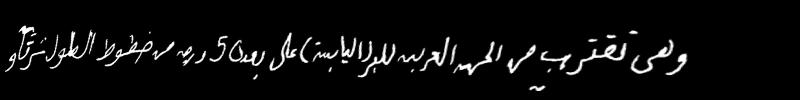

In [14]:
dataset["train"][2]["image"]

In [15]:
dataset["train"][2]["text"]

'وهى تقترب من الحهه العربيه للبر (اليابسة) على  بعد 50 درجه من خطوط الطول شرقآ و'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [16]:
instruction = "Please analyze the provided image and extract the handwritten text content accurately."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [17]:
converted_dataset_train = [convert_to_conversation(sample) for sample in dataset["train"]]
converted_dataset_test = [convert_to_conversation(sample) for sample in dataset["test"]]

We look at how the conversations are structured for the first example:

In [29]:
converted_dataset_train[2]


{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Please analyze the provided image and extract the handwritten text content accurately.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=800x100>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'وهى تقترب من الحهه العربيه للبر (اليابسة) على  بعد 50 درجه من خطوط الطول شرقآ و'}]}]}

In [28]:
converted_dataset_test[1]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Please analyze the provided image and extract the handwritten text content accurately.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=800x100>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'لزمتك. سألت راجح هل بلغ أصحابنا ظ ع ك ، ث خ ض، ب س ش، ص غ هـ أننا في الحج.'}]}]}

Let's first see before we do any finetuning what the model outputs for the first example!

In [30]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset["train"][2]["image"]
instruction = "Please analyze the provided image and extract the handwritten text content accurately."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

وسي تقترب من المهد العربي (البربرية) على بضع ربع مخطوط الطول ٢٥٥<|im_end|>


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [31]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset_train,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [32]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
2.291 GB of memory reserved.


In [33]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 27,300 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 28,950,528
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,3.062100
2,3.025500
3,3.016900
4,2.490400
5,2.372000
6,2.362200
7,1.823400
8,1.487800
9,1.294000
10,1.492100


In [34]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

156.2829 seconds used for training.
2.6 minutes used for training.
Peak reserved memory = 2.641 GB.
Peak reserved memory for training = 0.35 GB.
Peak reserved memory % of max memory = 17.908 %.
Peak reserved memory for training % of max memory = 2.373 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [35]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset["train"][2]["image"]
instruction = "Please analyze the provided image and extract the handwritten text content accurately."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

وفي تقريب من المهجر العربي (البربرية) عل بضع رؤيا مضطوط الطول ٢٥٠<|im_end|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

\frac { N } { M } \in \mathbb { Z } , \frac { M } { P } \in \mathbb { Z } , \frac { P } { Q } \in \mathbb { Z }<|im_end|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Llama 3.2 Conversational notebook. [Free Colab](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/drive/1j0N4XTY1zXXy7mPAhOC1_gMYZ2F2EBlk?usp=sharing)
4. Qwen 2 VL Vision finetuning - Maths OCR to LaTeX. [Free Colab](https://colab.research.google.com/drive/1whHb54GNZMrNxIsi2wm2EY_-Pvo2QyKh?usp=sharing)
5. Pixtral 12B Vision finetuning - General QA datasets. [Free Colab](https://colab.research.google.com/drive/1K9ZrdwvZRE96qGkCq_e88FgV3MLnymQq?usp=sharing)
6. More notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [Github](https://github.com/unslothai/unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>